In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
import os

In [3]:
import imageio as io
import skimage
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6057071172412436174
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6686252073
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2351593503484095647
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1



In [6]:
class DataFeeder:
    
    def generateDataRefArray(self): #generates a random array sequence
        numberOfClasses = len(self.classPathes)
        numberOfDataPerClass = np.zeros(numberOfClasses, dtype = "uint16")
        numberOfData = 0
        for nb,subPathName in enumerate(self.classPathes):
            folder_path = os.path.join(self.path, subPathName)
            numberOfDataPerClass[nb] = len(os.listdir(folder_path))
            numberOfData += numberOfDataPerClass[nb]
        
        dataArray = np.zeros((numberOfData,2),dtype = "uint16")
        numberOfDataAdded = 0
        for i in range(numberOfClasses):
            dataPerClass = numberOfDataPerClass[i]
            dataArray[numberOfDataAdded:numberOfDataAdded+dataPerClass,0] = np.arange(dataPerClass)
            dataArray[numberOfDataAdded:numberOfDataAdded+dataPerClass,1] = np.zeros(dataPerClass) + i
            numberOfDataAdded += dataPerClass
        
        np.random.shuffle(dataArray)
        self.dataArray = dataArray
        self.numberOfData = len(dataArray)
    
    def getNumberOfSteps(self):
        return int((1  - self.validPercent)*(self.numberOfData)/(self.batchSize))
    
    def __init__(self, path, classPathes, validPercent, batchSize = 32, imgSize = (64,64)):
        self.path = path
        self.classPathes = classPathes
        self.validPercent = validPercent
        self.generateDataRefArray()
        self.batchSize = batchSize
        self.imgSize = imgSize
    
    def generatorTrainData(self): #iterator for training (x first index, y second index)
        while True:
            for i in self.generator(0,int(len(self.dataArray)*(1  - self.validPercent))):
                yield(i)#yields all train
        
    def getValidData(self):
        testX = []
        testY = []
        for batch in self.generator(int(len(self.dataArray)*(1  - self.validPercent)),int(len(self.dataArray))):
            testX.append(batch[0])
            testY.append(batch[1])
        return np.array(np.concatenate(testX)),np.array(np.concatenate(testY))
    
    def generator(self,minIndex,maxIndex): #iterator from minIndex to maxIndex
        batchX = []
        batchY = []
        batchCount = 0
        for i in self.dataArray[int(minIndex):int(maxIndex)]:
            dataNumber  = i[0]
            classNumber = i[1]
            folder_path = os.path.join(self.path, self.classPathes[classNumber])
            imgPath = os.path.join(folder_path, os.listdir(folder_path)[dataNumber])
            img = io.imread(imgPath)
            image_resized = skimage.transform.resize(img, self.imgSize,
                           anti_aliasing=True)
            imgAsFloat = skimage.img_as_float(image_resized)
            modifiedImageShape = (imgAsFloat.shape[0],imgAsFloat.shape[1],3)
            if imgAsFloat.shape != modifiedImageShape:
                print("grey img :", imgPath)
                continue
            batchCount += 1
            batchX.append(imgAsFloat)
            batchY.append(classNumber)
            if batchCount == self.batchSize:
                batchX =np.array(batchX)
                batchY = np.array(batchY)
                yield((batchX,batchY))
                batchCount = 0
                batchX = []
                batchY = []
        if batchCount > 0:
            batchX =np.array(batchX)
            batchY = np.array(batchY)
            yield((batchX,batchY))

In [7]:
datafeeder = DataFeeder("PetImages",["Cat","Dog"],0.005, imgSize = (128,128))

In [8]:
datafeeder.getNumberOfSteps()

728

In [9]:
testX,testY = datafeeder.getValidData()

118
(128, 128, 3)
0.4576271186440678


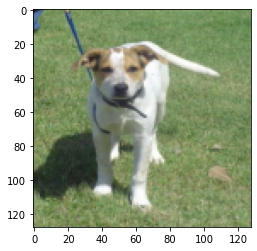

In [10]:
randVal = np.random.randint(len(testX))

print(len(testX))
print(testX[randVal].shape)
print(sum(testY)/len(testX))
randVal = np.random.randint(len(testX))
plt.imshow(testX[randVal])

In [11]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 3, input_shape=testX[randVal].shape))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(64, 3, input_shape=testX[randVal].shape))
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(128, 3, padding='same'))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(128, 3, padding='same'))
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(256, 3, padding='same'))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(256, 3, padding='same'))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(256, 3, padding='same'))
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(512, 3, padding='same'))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(512, 3, padding='same'))
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv2D(512, 3, padding='same'))
model.add(keras.layers.ReLU())

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.ReLU())

model.add(keras.layers.Dense(500))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.ReLU())


model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation('sigmoid'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
re_lu (ReLU)                 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 62, 62, 128)       0

In [13]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
EPOCHS = 20

In [14]:
model.outputs

[<tf.Tensor 'activation/Identity:0' shape=(None, 1) dtype=float32>]

In [15]:
H = model.fit(x = datafeeder.generatorTrainData(),
              validation_data = (testX, testY),
              epochs = EPOCHS, steps_per_epoch = int(datafeeder.getNumberOfSteps()))

  ...
    to  
  ['...']
Train for 728 steps, validate on 118 samples
Epoch 1/20
728/728 [==============================] - 893s 1s/step - loss: 0.6643 - accuracy: 0.5881 - val_loss: 0.5852 - val_accuracy: 0.7034
Epoch 2/20
728/728 [==============================] - 523s 718ms/step - loss: 0.5633 - accuracy: 0.7132 - val_loss: 0.4511 - val_accuracy: 0.7966
Epoch 3/20
728/728 [==============================] - 512s 704ms/step - loss: 0.4616 - accuracy: 0.7829 - val_loss: 0.4673 - val_accuracy: 0.8051
Epoch 4/20
728/728 [==============================] - 513s 705ms/step - loss: 0.3703 - accuracy: 0.8330 - val_loss: 0.3234 - val_accuracy: 0.8729
Epoch 5/20
728/728 [==============================] - 512s 704ms/step - loss: 0.2961 - accuracy: 0.8746 - val_loss: 0.3108 - val_accuracy: 0.8644
Epoch 6/20
728/728 [==============================] - 513s 705ms/step - loss: 0.2460 - accuracy: 0.9002 - val_loss: 0.2020 - val_accuracy: 0.8983
Epoch 7/20
728/728 [==============================] - 514

728/728 [==============================] - 528s 725ms/step - loss: 0.1402 - accuracy: 0.9485 - val_loss: 0.5690 - val_accuracy: 0.8475
Epoch 12/20
728/728 [==============================] - 527s 724ms/step - loss: 0.1278 - accuracy: 0.9543 - val_loss: 0.5715 - val_accuracy: 0.8983
Epoch 13/20
728/728 [==============================] - 527s 724ms/step - loss: 0.1258 - accuracy: 0.9559 - val_loss: 1.0195 - val_accuracy: 0.8644
Epoch 14/20
728/728 [==============================] - 529s 727ms/step - loss: 0.1123 - accuracy: 0.9603 - val_loss: 0.3096 - val_accuracy: 0.9153
Epoch 15/20
728/728 [==============================] - 530s 728ms/step - loss: 0.1176 - accuracy: 0.9606 - val_loss: 0.3160 - val_accuracy: 0.9322
Epoch 16/20
728/728 [==============================] - 525s 721ms/step - loss: 0.1065 - accuracy: 0.9636 - val_loss: 0.3290 - val_accuracy: 0.9322
Epoch 17/20
728/728 [==============================] - 526s 722ms/step - loss: 0.1158 - accuracy: 0.9638 - val_loss: 0.1456 - val_

testX size =  118


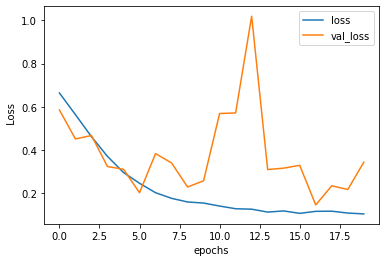

In [16]:
for key in ["loss","val_loss"]:
    plt.plot(np.arange(len(H.history.get(key))), np.array(H.history.get(key)),label = key)
plt.legend()
plt.xlabel("epochs")
plt.ylabel(" Loss")
print("testX size = ",len(testX))

testX size =  118


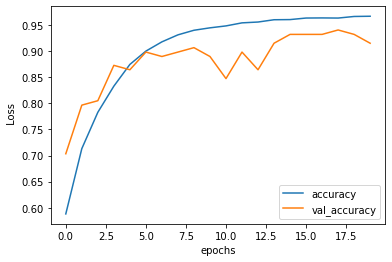

In [17]:
for key in ["accuracy","val_accuracy"]:
    plt.plot(np.arange(len(H.history.get(key))), np.array(H.history.get(key)),label = key)
plt.legend()
plt.xlabel("epochs")
plt.ylabel(" Loss")
print("testX size = ",len(testX))

[[0.9998211]]


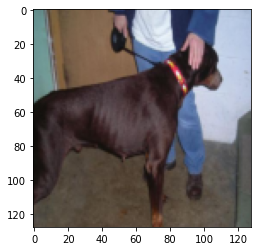

In [83]:
randVal = np.random.randint(len(testX))
plt.imshow(testX[randVal])
print(model.predict(np.array([testX[randVal]])))

In [19]:
myFeeder = DataFeeder("PersonnalImages",["Cat","huamn"],1.0, imgSize = (128,128))

In [20]:
mesChats = myFeeder.getValidData()

grey img : PersonnalImages\huamn\paul.PNG


In [21]:
mesChats = mesChats[0]

In [22]:
len(mesChats)

7

[[4.198086e-09]]


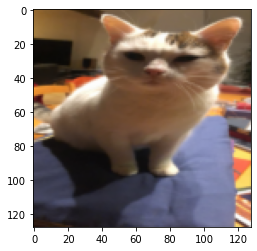

In [49]:
randVal = np.random.randint(len(mesChats))
plt.imshow(mesChats[randVal])
print(model.predict(np.array([mesChats[randVal]])))